## Here a sensitiivity framework builduing on the work by Chas and AlexR is developed. <br>
Work in progress <br>
AlexF 20190813


In [1]:
import numpy as np
import pickle as pkl
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib import mlab as mlab
from matplotlib.mlab import psd


In [89]:

# determine the center position of the attractor at a given time
def osci_pos_func(stroke,time,frequency): 
    osci_pos = stroke/2*np.sin(2*np.pi*time*frequency)
    return osci_pos

# determine the force for a given point in time using the transformation to position
def osci_force_func(stroke,time,frequency,pos_vec,force_vec):
    osci_pos = osci_pos_func(stroke,time,frequency)
    return np.interp(osci_pos,pos_vec,force_vec, left=None, right=None, period=None)

# normalization for used PSD
def fft_norm(N, fsamp):
    return np.sqrt(2 / (N * fsamp))

In [90]:
## load the data dictionary file (its usually of the form results_dic[rbead][sep][height][yuklambda])
res_dict_side_by_side = pkl.load( open('results/rbead_2.4e-06_sep_7.5e-06_height_0.p', 'rb'))


In [91]:
## initate a few values in order to do diagnostics
int_time = 1 # keep that 1 for now
alpha = 1 # alpha to scale the yukawa force
sampling_frequency = 5000 # should be 5000 
time = np.arange(0,int_time,1/sampling_frequency) # make a time array
separation = 7.5e-6 # separation is set by the file you load TODO automatize
lambda_par= 1e-5 # pick a lambda parameter
force_x = res_dict_side_by_side[2.4e-6][separation][0][lambda_par][0] # force in direction of the sphere
force_x_yuk = alpha*res_dict_side_by_side[2.4e-6][separation][0][lambda_par][3] # force by the yukawa potential
pos_x = res_dict_side_by_side["posvec"] # get the position of the bead from the dictionary



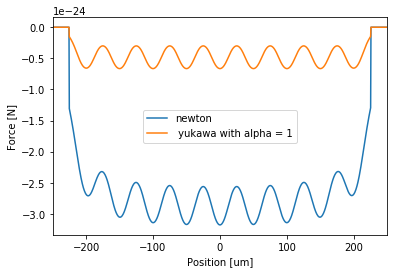

In [92]:
# let's have a look at the force in the spatial dimension

plt.plot(1e6*pos_x,force_x, label = "newton")
plt.plot(1e6*pos_x,force_x_yuk, label = " yukawa with alpha = %d" %alpha)
plt.ylabel("Force [N]",)
plt.xlabel("Position [um]")
plt.xlim(-250,250)
plt.legend()

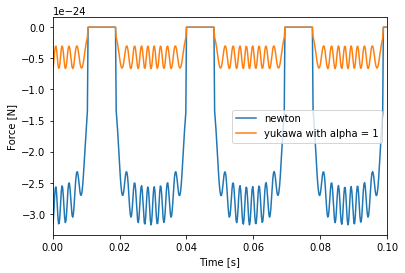

In [97]:
# now force as a function of time

plt.plot(time,osci_force_func(500e-6,time,17,pos_x,force_x), label="newton")
plt.plot(time,osci_force_func(500e-6,time,17,pos_x,force_x_yuk), label =  "yukawa with alpha = %d" %alpha)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.xlim(0,0.1)
plt.legend()

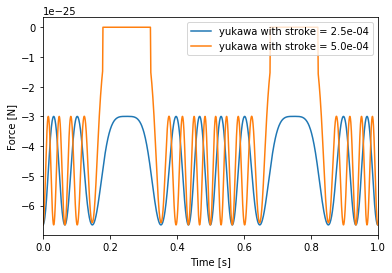

In [115]:
# now force as a function of time with different strokes
stroke1=250e-6
stroke2=500e-6
plt.plot(time,osci_force_func(stroke1,time,1,pos_x,force_x_yuk), label =  "yukawa with stroke = %2.1e" %stroke1)
plt.plot(time,osci_force_func(stroke2,time,1,pos_x,force_x_yuk), label =  "yukawa with stroke = %2.1e" %stroke2)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.xlim(0,1)
plt.legend()

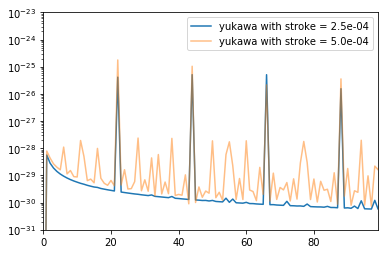

In [123]:
frequency = 11
psd_dat,freq = psd(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk), 
                   NFFT=len(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk)), Fs=5000, detrend="linear",
        window=mlab.window_none, noverlap=0, pad_to=None)

psd_dat2,freq2 = psd(osci_force_func(stroke2,time,frequency,pos_x,force_x_yuk),
                     NFFT=len(osci_force_func(stroke2,time,frequency,pos_x,force_x_yuk)),Fs=5000, detrend="linear",
        window=mlab.window_none, noverlap=0, pad_to=None)

plt.plot(freq,np.sqrt(psd_dat),label =  "yukawa with stroke = %2.1e" %stroke1)
plt.plot(freq2,np.sqrt(psd_dat2),alpha=0.5,label =  "yukawa with stroke = %2.1e" %stroke2)
plt.yscale("log")
#plt.xscale("log")
plt.xlim(0,99)
plt.ylim(1e-31,1e-23)
plt.legend()
#plt.xscale("log")

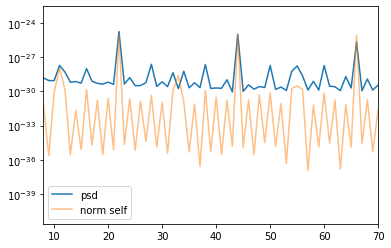

In [124]:
fft = np.abs(np.fft.rfft(osci_force_func(stroke1,time,frequency,pos_x,force_x)))
freq3 = np.fft.rfftfreq(5000, d=1./5000)
ps = fft*fft.conj().real*fft_norm(len(osci_force_func(stroke1,time,frequency,pos_x,force_x)),5000)**2

plt.plot(freq2,np.sqrt(psd_dat2),label="psd")
plt.plot(freq3,np.sqrt(ps),alpha=0.5, label = "norm self")
plt.yscale("log")
plt.xlim(8,70)
#plt.ylim(1e-40,1e-22)
plt.legend()
plt.show()

In [125]:
def function_response(alpha,int_time,sampling_frequency,pos_vec,force_vec,stroke,frequency,no_harmonics,plot):
    force_vec = force_vec * alpha
    sampling_frequency = 5000
    time = np.arange(0,int_time,1/sampling_frequency)
    psd_dat2,freq2 = psd(osci_force_func(stroke,time,frequency,pos_vec,force_vec), 
                         NFFT=len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)), 
                         Fs=5000, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response =0
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,340)
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(psd_dat2[i*frequency])
        #print(response,i*frequency)
    return response

In [609]:
alpha_list=[]
noise_floor = 1e-18 # N
no_of_harmonics=3#np.arange(1,100,1)
stroke = np.arange(50e-6,550e-6,50e-6)
integration_time_simple = 1e5
for j in stroke:
    for i in np.geomspace(1,1e9,256):
        f = function_response(i,1,1,5000,pos_x,force_x_yuk,j,10,no_of_harmonics,plot=False)
        #print(f)
        if(f>(noise_floor*no_of_harmonics/np.sqrt(integration_time_simple))):
            #print("The maximum alpha is %2.2E with %.2d harmonics" %(i,j))
            alpha_list.append(i)
            break



The minimum is at 1.24E+04 at 01 harmonics


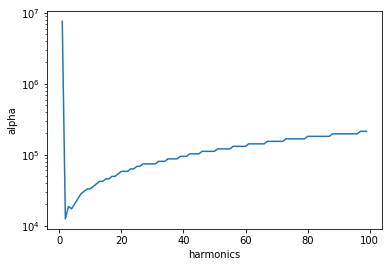

In [592]:
plt.plot(no_of_harmonics,alpha_list)            
plt.yscale("log")
plt.ylabel("alpha")
plt.xlabel("harmonics")
print("The minimum is at %2.2E at %.2d harmonics" %(np.min(alpha_list),np.argmin(alpha_list)))
plt.show()

The minimum is at 8.97E+03 


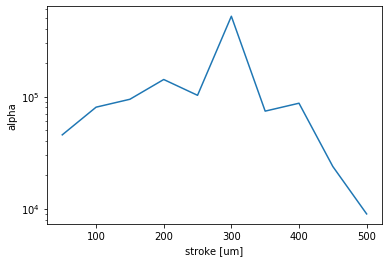

In [610]:
plt.plot(stroke*1e6,alpha_list)            
plt.yscale("log")
plt.ylabel("alpha")
plt.xlabel("stroke [um]")
print("The minimum is at %2.2E " %(np.min(alpha_list)))
plt.show()

/home/data_transfer/data_from_windows/20190812/Bead1/InitialTest/Data42.h5
No cantilever data


(0, 340)

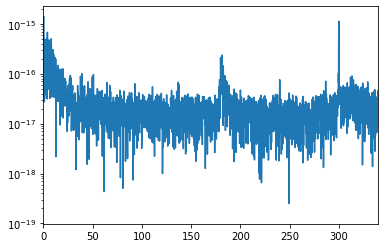

In [637]:
## load real noise spectrum
import numpy as np
import pickle as pickle
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib.mlab import psd

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
Year = "2019"
Month = "08"
Day = "12"
BeadNumber = 1
folder = r"/home/data_transfer/data_from_windows/"+ Year + Month + Day
Data_File_Number=42
fname = folder+"/Bead"+str(BeadNumber)+"/InitialTest"+"/Data%d.h5" % Data_File_Number
print(fname)
BDF = BeadDataFile.BeadDataFile(fname)
fsamp=5000
res = 50000
#res=50000
data=BDF.xyz
data_det=signal.detrend(data)
y_1000=1*data_det[1]
z_1000=100*data_det[2]
xpsd, freqs = psd(data_det[0], Fs = fsamp, NFFT = res)
ypsd, freqs = psd(y_1000, Fs = fsamp, NFFT = res)
zpsd, freqs = psd(z_1000, Fs = fsamp, NFFT = res)
plt.plot(freqs,noise_floor/np.sqrt(xpsd[121*10])*np.sqrt(xpsd))
plt.yscale("log")
plt.xlim(0,340)


In [624]:
len(xpsd)

25001

In [641]:
def noise_response(data,frequency,no_harmonics,normalization=1):
    response=0
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(data[i*frequency*10])
        #print(response,i*frequency)
    return response*normalization

6.2711886904440515e-18
3.16227766016838e-20
1.7730784090655124e-18


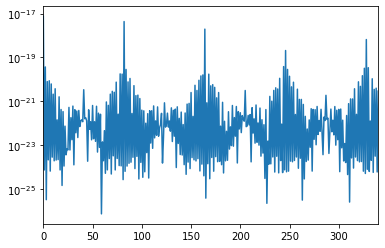

In [681]:
noise_floor = 1e-18 # N
integration_time_simple = 1000
no_of_harmonics=5
frequency=41
print(function_response(4e6,1,5000,pos_x,force_x_yuk,500e-6,frequency,no_of_harmonics,plot=True))
print(noise_floor/np.sqrt(integration_time_simple))
print(noise_response(np.sqrt(xpsd),frequency,no_of_harmonics,noise_floor/np.sqrt(xpsd[121*10])))

In [477]:
# my_to_do_list

# harmonics vs alpha (mo) - done
# comparison as a function of integration time (mo) - done
# comparison as a function of stroke with harmonics (mo) - done
# comparison vs real noise (mo) - basically implemented
# comparison for different frequencies (mo) - 
# make the script nice (di) - tried
# do different lambda (di)
# do different separation (di)
# implement confidence intervall
# implement noise random 
# implement different functions for shaking
# in and out (mi+do)
# second attractor (fr)
# change attractor - finger size, size, finger pattern (future)
# use peak height information for likelihood comparison